In [265]:
# === Hücre 1: Kütüphane Yükleme ve Yol Kontrolü ===
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import ipywidgets as widgets   # etkileşimli widget'lar için ekledik

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
GEOLIFE_PATH = RAW_DATA_PATH / "geolife"
DATA_DIR = GEOLIFE_PATH / "Data"

print("== Yol Kontrolü ==")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Veri dizini bulunamadı: {DATA_DIR}")
else:
    print(f"Veri dizini bulundu: {DATA_DIR}")

# Sağlık kontrolü
user_folders = [d for d in DATA_DIR.iterdir() if d.is_dir()]
plt_count = 0
for u in user_folders:
    traj_dir = u / "Trajectory"
    if traj_dir.exists():
        plt_count += len(list(traj_dir.glob("*.plt")))

print(f"Kullanıcı klasörü sayısı : {len(user_folders)} (≈181 beklenir)")
print(f"Toplam .plt dosyası      : {plt_count} (≈18k beklenir)")

# Örnek dosya
if user_folders:
    sample_file = None
    for u in user_folders:
        traj_dir = u / "Trajectory"
        if traj_dir.exists():
            found = list(traj_dir.glob("*.plt"))
            if found:
                sample_file = found[0]
                break
    if sample_file is not None:
        print(f"Örnek dosya: {sample_file}")
    else:
        print("Uyarı: Kullanıcı klasörlerinde .plt dosyası bulunamadı.")
else:
    print("Uyarı: Kullanıcı klasörü bulunamadı.")

print("Hücre 1 tamam.")


== Yol Kontrolü ==
Veri dizini bulundu: /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data
Kullanıcı klasörü sayısı : 182 (≈181 beklenir)
Toplam .plt dosyası      : 18670 (≈18k beklenir)
Örnek dosya: /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data/135/Trajectory/20090103012134.plt
Hücre 1 tamam.


In [266]:
# === Hücre 2a: Geolife .plt ham görünüm + hızlı meta ===
from pathlib import Path

# 1) Örnek dosya (Hücre 1'den geldiyse kullan; yoksa ilkini bul)
try:
    _ = sample_file
except NameError:
    DATA_DIR = Path("/Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data")
    users = [d for d in DATA_DIR.iterdir() if d.is_dir()]
    sample_file = None
    for u in users:
        t = u / "Trajectory"
        if t.exists():
            found = list(t.glob("*.plt"))
            if found:
                sample_file = found[0]
                break

sf = Path(sample_file) if sample_file else None
if not sf or not sf.exists():
    raise FileNotFoundError("Örnek .plt dosyası bulunamadı.")

print("== Ham Dosya İncelemesi ==")
print(f"Dosya  : {sf}")
print(f"Boyut  : {sf.stat().st_size:,} bayt")

# 2) Satır sayısı (hızlı sayım)
with sf.open("r", encoding="utf-8", errors="ignore") as f:
    line_count = sum(1 for _ in f)
print(f"Satır  : {line_count}")

# 3) İlk 12 satırı göster
print("\n-- İlk 12 satır (ham) --")
first_lines = []
with sf.open("r", encoding="utf-8", errors="ignore") as f:
    for i, line in enumerate(f):
        if i < 12:
            first_lines.append(line.rstrip("\n"))
        else:
            break
for i, line in enumerate(first_lines):
    print(f"{i:02d}: {line}")

# 4) Şema kontrolü: ilk veri satırını parçala
data_line = None
for line in first_lines[6:]:
    if line.strip() and not line.lower().startswith(("#", "latitude")):
        data_line = line
        break

warns = []
if data_line is None:
    warns.append("İlk 12 satır içinde veri satırı bulamadım (dosya çok kısa olabilir).")
else:
    parts = [p.strip() for p in data_line.split(",")]
    print("\n-- İlk veri satırı alan sayısı --")
    print(f"Alan sayısı: {len(parts)} -> {parts}")
    if len(parts) != 7:
        warns.append(f"Beklenen 7 alan; gördüğüm {len(parts)}. (Şema farklı olabilir)")

# 5) Meta başlıklar bekleniyor mu?
if first_lines and "Geolife Trajectory" not in (first_lines[0] or ""):
    warns.append("1. satırda 'Geolife Trajectory' başlığı görünmüyor (farklı sürüm?).")

# 6) Uyarıları yazdır
if warns:
    print("\nUyarılar:")
    for w in warns:
        print(" -", w)
else:
    print("\n✓ Şema ve başlıklar beklenen görünüyor.")

print("\nHücre 2a tamam.")


== Ham Dosya İncelemesi ==
Dosya  : /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data/135/Trajectory/20090103012134.plt
Boyut  : 154,320 bayt
Satır  : 2397

-- İlk 12 satır (ham) --
00: Geolife trajectory
01: WGS 84
02: Altitude is in Feet
03: Reserved 3
04: 0,2,255,My Track,0,0,2,8421376
05: 0
06: 39.974294,116.399741,0,492,39816.0566435185,2009-01-03,01:21:34
07: 39.974292,116.399592,0,492,39816.0566550926,2009-01-03,01:21:35
08: 39.974309,116.399523,0,492,39816.0566666667,2009-01-03,01:21:36
09: 39.97432,116.399588,0,492,39816.0566898148,2009-01-03,01:21:38
10: 39.974365,116.39973,0,491,39816.0567013889,2009-01-03,01:21:39
11: 39.974391,116.399782,0,491,39816.0567361111,2009-01-03,01:21:42

-- İlk veri satırı alan sayısı --
Alan sayısı: 7 -> ['39.974294', '116.399741', '0', '492', '39816.0566435185', '2009-01-03', '01:21:34']

Uyarılar:
 - 1. satırda 'Geolife Trajectory' başlığı görünmüyor (farklı sürüm?).

Hücre 2a tamam.


In [267]:
# === Hücre 2b: .plt -> DataFrame (tek dosya) + timestamp + sağlık kontrolleri ===

from pathlib import Path

# 0) Örnek dosya (Hücre 2a'dan)
# Tip denetleyiciyi memnun etmek ve None olasılığını elemek için güvenli kontrol:
try:
    _ = sample_file  # 2a'da bulunmuş olmalı
except NameError:
    sample_file = None

if sample_file is None:
    raise FileNotFoundError("Örnek .plt dosyası bulunamadı (sample_file=None).")

if not isinstance(sample_file, (str, Path)):
    raise TypeError(f"sample_file beklenmeyen tipte: {type(sample_file)!r}")

sf = Path(sample_file)
assert sf.exists(), f"Dosya yok: {sf}"

# 1) Şema
COLS = ["lat", "lon", "unused", "alt_ft", "days", "date", "time"]

# 2) Okuma (ilk 6 satırı atla)
df = pd.read_csv(
    sf,
    skiprows=6,
    header=None,
    names=COLS,
    dtype={
        "lat": "float64",
        "lon": "float64",
        "unused": "float64",
        "alt_ft": "float64",
        "days": "float64",
        "date": "string",
        "time": "string",
    },
    na_values=["", "NaN", "nan"],
    encoding="utf-8",
)

# 3) Timestamp / türevler
df["ts"] = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str), errors="coerce")
df["alt_m"] = df["alt_ft"] * 0.3048

# 4) Temizlik (opsiyonel minik)
before = len(df)
df = df.dropna(subset=["lat", "lon", "ts"]).copy()
after = len(df)

# 5) Hızlı sağlık kontrolleri
problems: list[str] = []

# NaN oranları
nan_rate = (df[["lat", "lon", "alt_ft", "alt_m", "ts"]].isna().mean() * 100).round(2)

# Lat/Lon aralık kontrolü
bad_lat = (~df["lat"].between(-90, 90)).sum()
bad_lon = (~df["lon"].between(-180, 180)).sum()
if bad_lat or bad_lon:
    problems.append(f"Aralık dışı koordinat: lat={bad_lat}, lon={bad_lon}")

# Zaman sırası & tekrarlar
df = df.sort_values("ts")
dup_ts = df["ts"].duplicated().sum()
non_increasing = (df["ts"].diff().dt.total_seconds() < 0).sum()
if dup_ts:
    problems.append(f"Tekrarlayan timestamp: {dup_ts}")
if non_increasing:
    problems.append(f"Zaman geriye gitmiş: {non_increasing}")

# Kapsam (başlangıç-bitiş)
tmin, tmax = df["ts"].min(), df["ts"].max()
duration_min = (
    (tmax - tmin).total_seconds() / 60 if pd.notna(tmin) and pd.notna(tmax) else None
)

# 6) Özet yazdır
print("== Parser çıktısı ==")
print(f"Dosya       : {sf.name}")
print(f"Şekil       : {df.shape} (okunan {before}, temiz kalan {after})")
print(
    f"Zaman aralığı: {tmin}  →  {tmax}  (~{duration_min:.1f} dk)"
    if duration_min is not None
    else "Zaman aralığı: -"
)
print("\nNaN oranları (%):")
print(nan_rate.to_string())

if problems:
    print("\n Uyarılar:")
    for p in problems:
        print(" -", p)
else:
    print("\n✓ Sağlık kontrolleri temiz görünüyor.")

print("\n-- İlk 5 satır --")
print(df.head(5))

print("\nHücre 2b tamam.")


== Parser çıktısı ==
Dosya       : 20090103012134.plt
Şekil       : (2391, 9) (okunan 2391, temiz kalan 2391)
Zaman aralığı: 2009-01-03 01:21:34  →  2009-01-03 05:40:31  (~258.9 dk)

NaN oranları (%):
lat       0.0
lon       0.0
alt_ft    0.0
alt_m     0.0
ts        0.0

✓ Sağlık kontrolleri temiz görünüyor.

-- İlk 5 satır --
         lat         lon  unused  alt_ft          days        date      time  \
0  39.974294  116.399741     0.0   492.0  39816.056644  2009-01-03  01:21:34   
1  39.974292  116.399592     0.0   492.0  39816.056655  2009-01-03  01:21:35   
2  39.974309  116.399523     0.0   492.0  39816.056667  2009-01-03  01:21:36   
3  39.974320  116.399588     0.0   492.0  39816.056690  2009-01-03  01:21:38   
4  39.974365  116.399730     0.0   491.0  39816.056701  2009-01-03  01:21:39   

                   ts     alt_m  
0 2009-01-03 01:21:34  149.9616  
1 2009-01-03 01:21:35  149.9616  
2 2009-01-03 01:21:36  149.9616  
3 2009-01-03 01:21:38  149.9616  
4 2009-01-03 01:21:3

In [268]:
# === Hücre 2c: zaman/mesafe/hız türet + sağlık kontrolü ===

import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt

assert 'df' in globals(), "df yok. Önce 2b parser hücresini çalıştırın (df üretir)."

def haversine_m(lat1, lon1, lat2, lon2):
    # tüm girdiler numpy array olabilir
    R = 6371000.0  # metre
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2.0)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df2 = df.copy()

# 1) kronolojik sırala ve yinelenen timestamp'i ele
df2 = df2.sort_values('ts').drop_duplicates('ts').reset_index(drop=True)

# 2) farklar
df2['dt_s']   = df2['ts'].diff().dt.total_seconds().fillna(0)
df2['dist_m'] = 0.0
if len(df2) > 1:
    df2.loc[1:, 'dist_m'] = haversine_m(
        df2['lat'].values[:-1], df2['lon'].values[:-1],
        df2['lat'].values[1:],  df2['lon'].values[1:]
    )

# 3) hızlar
eps = 1e-6
df2['speed_mps'] = df2['dist_m'] / np.maximum(df2['dt_s'], eps)
df2['speed_kmh'] = df2['speed_mps'] * 3.6

# 4) hızlı sağlık/temizlik bayrakları (domain'e göre esnek)
#    - dt <= 0 (zaman geri gitmiş)
#    - dist çok büyük “tek adım” (ör. 5km+)
#    - speed aşırı (ör. 200 km/s üzeri)
df2['flag_dt_le0']   = df2['dt_s'] <= 0
df2['flag_longjump'] = df2['dist_m'] > 5000
df2['flag_v_extreme']= df2['speed_kmh'] > 200

# 5) özet rapor
n = len(df2)
print("== Türev metrikler (tek dosya) ==")
print(f"Satır         : {n}")
print(f"Süre (dk)     : { (df2['dt_s'].sum()/60):.1f}")
print(f"Toplam mesafe : { df2['dist_m'].sum()/1000:.2f} km")
print(f"Ort. hız      : { df2['speed_kmh'].replace([np.inf, -np.inf], np.nan).mean():.2f} km/h")

print("\n-- Uyarı bayrak sayıları --")
flags = {
    'dt<=0'      : int(df2['flag_dt_le0'].sum()),
    'long_jump'  : int(df2['flag_longjump'].sum()),
    'v>200km/h'  : int(df2['flag_v_extreme'].sum()),
}
print(flags)

if any(flags.values()):
    print("\nÖrnek satırlar (bayraklı):")
    display(df2.loc[df2[['flag_dt_le0','flag_longjump','flag_v_extreme']].any(axis=1)].head(10))

print("\n-- İlk 5 satır --")
display(df2.head())

# (opsiyonel) geçici kaydetme
# df2.to_parquet("data/processed/sample_with_speed.parquet", index=False)
# print("Kaydedildi: data/processed/sample_with_speed.parquet")

# Sonucu ileride tekrar kullanmak üzere global adıyla da bırakalım:
df_metrics = df2
print("\nHücre 2c tamam.")


== Türev metrikler (tek dosya) ==
Satır         : 2391
Süre (dk)     : 258.9
Toplam mesafe : 9.55 km
Ort. hız      : 4.22 km/h

-- Uyarı bayrak sayıları --
{'dt<=0': 1, 'long_jump': 0, 'v>200km/h': 0}

Örnek satırlar (bayraklı):


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,dist_m,speed_mps,speed_kmh,flag_dt_le0,flag_longjump,flag_v_extreme
0,39.974294,116.399741,0.0,492.0,39816.056644,2009-01-03,01:21:34,2009-01-03 01:21:34,149.9616,0.0,0.0,0.0,0.0,True,False,False



-- İlk 5 satır --


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,dist_m,speed_mps,speed_kmh,flag_dt_le0,flag_longjump,flag_v_extreme
0,39.974294,116.399741,0.0,492.0,39816.056644,2009-01-03,01:21:34,2009-01-03 01:21:34,149.9616,0.0,0.000000,0.000000,0.000000,True,False,False
1,39.974292,116.399592,0.0,492.0,39816.056655,2009-01-03,01:21:35,2009-01-03 01:21:35,149.9616,1.0,12.698583,12.698583,45.714897,False,False,False
2,39.974309,116.399523,0.0,492.0,39816.056667,2009-01-03,01:21:36,2009-01-03 01:21:36,149.9616,1.0,6.176047,6.176047,22.233770,False,False,False
3,39.974320,116.399588,0.0,492.0,39816.056690,2009-01-03,01:21:38,2009-01-03 01:21:38,149.9616,2.0,5.672246,2.836123,10.210043,False,False,False
4,39.974365,116.399730,0.0,491.0,39816.056701,2009-01-03,01:21:39,2009-01-03 01:21:39,149.6568,1.0,13.093935,13.093935,47.138164,False,False,False



Hücre 2c tamam.


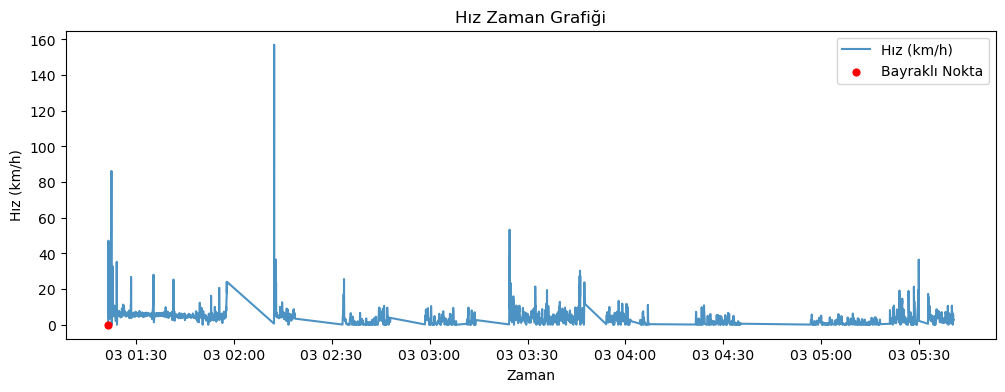

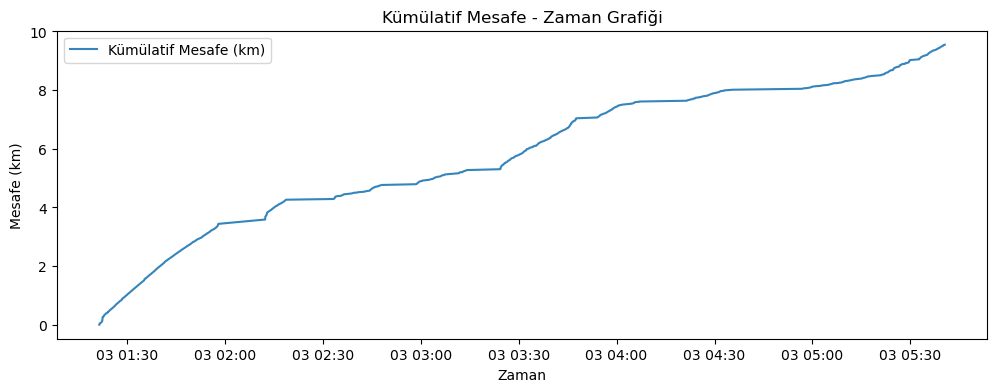

In [269]:

# === 2d Güvenli Başlangıç: türev kolonlar yoksa yerinde üret ===

import numpy as np
import matplotlib.pyplot as plt

need_base = {"ts", "lat", "lon"}
if not need_base.issubset(df.columns):
    raise ValueError("df beklenen ham kolonları içermiyor (ts, lat, lon). 2b/2c'yi çalıştır.")

have_metrics = {"dt_s", "dist_m", "speed_mps", "speed_kmh"}.issubset(df.columns)

if not have_metrics:
    # Haversine (metre)
    def haversine_m(lat1, lon1, lat2, lon2):
        R = 6371000.0
        lat1 = np.radians(lat1)
        lon1 = np.radians(lon1)
        lat2 = np.radians(lat2)
        lon2 = np.radians(lon2)
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        return 2 * R * np.arcsin(np.sqrt(a))

    # Zaman farkı (sn)
    df = df.sort_values("ts").copy()
    df["dt_s"] = df["ts"].diff().dt.total_seconds().fillna(0)

    # Konum farkı -> mesafe (m)
    d = haversine_m(df["lat"].shift(), df["lon"].shift(), df["lat"], df["lon"])
    # dt<=0 olan ve/veya NaN olan yerleri 0 yap
    df["dist_m"] = np.where(df["dt_s"].to_numpy() > 0, np.nan_to_num(d.to_numpy(), nan=0.0), 0.0)

    # Hız (m/s, km/h)
    eps = 1e-6
    df["speed_mps"] = df["dist_m"] / np.maximum(df["dt_s"], eps)
    df["speed_kmh"] = df["speed_mps"] * 3.6

# === Bayraklar: yoksa üret (have_metrics True olsa bile güvence) ===
if "flag_dt_le0" not in df.columns:
    df["flag_dt_le0"] = df["dt_s"] <= 0
if "flag_longjump" not in df.columns:
    df["flag_longjump"] = df["dist_m"] > 1000        # eşiğini istediğin gibi değiştir
if "flag_v_extreme" not in df.columns:
    df["flag_v_extreme"] = df["speed_kmh"] > 200     # eşiğini istediğin gibi değiştir


# Hız grafiği
plt.figure(figsize=(12, 4))
plt.plot(df["ts"], df["speed_kmh"], label="Hız (km/h)", alpha=0.8)

mask_flags = df["flag_dt_le0"] | df["flag_longjump"] | df["flag_v_extreme"]
if mask_flags.any():
    plt.scatter(
        df.loc[mask_flags, "ts"],
        df.loc[mask_flags, "speed_kmh"],
        color="red",
        s=24,
        zorder=3,
        label="Bayraklı Nokta",
    )
plt.title("Hız Zaman Grafiği")
plt.xlabel("Zaman")
plt.ylabel("Hız (km/h)")
plt.legend()
plt.show()

# Kümülatif mesafe grafiği
plt.figure(figsize=(12, 4))
cum_km = df["dist_m"].fillna(0).cumsum() / 1000.0
plt.plot(df["ts"], cum_km, label="Kümülatif Mesafe (km)", alpha=0.9)
plt.title("Kümülatif Mesafe - Zaman Grafiği")
plt.xlabel("Zaman")
plt.ylabel("Mesafe (km)")
plt.legend()
plt.show()


In [270]:
# === Hücre 3a: Geolife -> toplu işleme, özet çıkarma ve diske yazma ===
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
DATA_DIR     = PROJECT_ROOT / "data" / "raw" / "geolife" / "Data"
OUT_DIR      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "tracks_parquet").mkdir(parents=True, exist_ok=True)

MAX_FILES = 200  # ilk tur için sınır; sonra artır
summ_rows = []

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def parse_geolife_plt(path: Path) -> pd.DataFrame:
    # Başlık 6 satır; sonra csv benzeri 7 alan
    df = pd.read_csv(
        path, skiprows=6, header=None,
        names=["lat","lon","unused","alt_ft","days","date","time"]
    )
    # temel tipler + timestamp + metreye dönüştürme
    df["ts"] = pd.to_datetime(df["date"] + " " + df["time"])
    df["alt_m"] = df["alt_ft"].astype(float) * 0.3048
    cols = ["lat","lon","unused","alt_ft","days","date","time","ts","alt_m"]
    return df[cols].copy()

def ensure_metrics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("ts").copy()
    if "dt_s" not in df.columns or "dist_m" not in df.columns or "speed_kmh" not in df.columns:
        df["dt_s"] = df["ts"].diff().dt.total_seconds().fillna(0)
        df["dist_m"] = 0.0
        mask = df["dt_s"] > 0
        df.loc[mask, "dist_m"] = haversine_m(
            df["lat"].shift(), df["lon"].shift(), df["lat"], df["lon"]
        )[mask].fillna(0)
        df["speed_mps"] = np.where(df["dt_s"] > 0, df["dist_m"] / df["dt_s"], 0.0)
        df["speed_kmh"] = df["speed_mps"] * 3.6
    # Bayraklar
    df["flag_dt_le0"]    = df["dt_s"] <= 0
    df["flag_longjump"]  = df["dist_m"] > 1000
    df["flag_v_extreme"] = df["speed_kmh"] > 200
    return df

def summarize_track(df: pd.DataFrame, file_path: Path) -> dict:
    dur_s   = float(df["dt_s"].sum())
    dist_km = float(df["dist_m"].sum()/1000)
    mean_k  = float(df["speed_kmh"].mean())
    max_k   = float(df["speed_kmh"].max())
    n_flags = {
        "n_dt_le0": int(df["flag_dt_le0"].sum()),
        "n_jump":   int(df["flag_longjump"].sum()),
        "n_v_ext":  int(df["flag_v_extreme"].sum()),
    }
    return dict(
        file=str(file_path),
        t_start=df["ts"].min(), t_end=df["ts"].max(),
        duration_min=dur_s/60.0, distance_km=dist_km,
        mean_speed_kmh=mean_k, max_speed_kmh=max_k,
        **n_flags, n_points=int(len(df))
    )

# Dosyaları topla
plt_files = []
for udir in sorted(DATA_DIR.iterdir()):
    traj_dir = udir / "Trajectory"
    if traj_dir.is_dir():
        plt_files.extend(sorted(traj_dir.glob("*.plt")))
    if len(plt_files) >= MAX_FILES:
        break
plt_files = plt_files[:MAX_FILES]

print(f"İşlenecek dosya sayısı: {len(plt_files)}")

for p in tqdm(plt_files):
    try:
        df_raw = parse_geolife_plt(p)
        df_met = ensure_metrics(df_raw)

        # İsteğe bağlı: uç değer temizliği (çok agresif değil)
        # Örn: negatif/0 dt_s olan satırlarda hız=0 olarak kalsın; uzun zıplamaları düşürmek istersen:
        # df_met = df_met.loc[~df_met["flag_longjump"]].copy()

        # track'i parquet olarak kaydet
        out_name = (OUT_DIR / "tracks_parquet" / (p.stem + ".parquet"))
        df_met.to_parquet(out_name, index=False)

        # özet satır
        summ_rows.append(summarize_track(df_met, p))

    except Exception as e:
        # sorunlu dosyayı logla ve devam et
        summ_rows.append(dict(file=str(p), error=str(e)))

# Özet tabloyu kaydet
summ = pd.DataFrame(summ_rows)
summ_path = OUT_DIR / "summaries.parquet"
summ.to_parquet(summ_path, index=False)
print(f"\nÖzet tablo kaydedildi: {summ_path}")
print("İlk 5 özet satır:")
display(summ.head())


İşlenecek dosya sayısı: 200


  0%|          | 0/200 [00:00<?, ?it/s]


Özet tablo kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/summaries.parquet
İlk 5 özet satır:


,file,t_start,t_end,duration_min,distance_km,mean_speed_kmh,max_speed_kmh,n_dt_le0,n_jump,n_v_ext,n_points
0,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-23 02:53:04,2008-10-23 11:11:12,498.133333,14.938621,8.072699,218.098618,1,2,1,908
1,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-24 02:09:59,2008-10-24 02:47:06,37.116667,1.303660,3.461894,104.127482,1,0,0,244
2,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-26 13:44:07,2008-10-26 15:04:07,80.000000,18.648325,10.550068,131.930315,1,3,0,745
3,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-27 11:54:49,2008-10-27 12:05:54,11.083333,1.895661,6.959865,19.374918,1,0,0,50
4,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-28 00:38:26,2008-10-28 05:03:42,265.266667,8.598824,3.691051,71.273991,1,0,0,1477


In [271]:
# === Hücre 3b: Özet tabloyu oku + kalite/kapsam kontrolü (QC) ===
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
OUT_DIR      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
SUMM_PATH    = OUT_DIR / "summaries.parquet"

df = pd.read_parquet(SUMM_PATH)

print("=== summaries.parquet temel şekil & kolonlar ===")
print(df.shape)
print(df.columns.tolist(), "\n")

# 1) NaN oranları
na_rate = df.isna().mean().sort_values(ascending=False)
print("== NaN oranları ==")
print(na_rate[na_rate>0])

# 2) Tarih aralığı
print("\n== Tarih aralığı ==")
print("t_start min:", df["t_start"].min())
print("t_end   max:", df["t_end"].max())

# 3) Süre tutarlılığı: (t_end - t_start) vs duration_min
dur_calc_min = (df["t_end"] - df["t_start"]).dt.total_seconds() / 60.0
df["duration_min_calc"] = dur_calc_min
df["duration_gap_min"]  = df["duration_min_calc"] - df["duration_min"]

gap_abs = df["duration_gap_min"].abs()
print("\n== Süre farkı istatistikleri (dakika) ==")
print(gap_abs.describe())

# 4) Zaman-ağırlıklı ortalama hız (km/h) ~ distance / duration
df["mean_speed_timeweighted_kmh"] = np.where(
    df["duration_min"]>0,
    df["distance_km"] / (df["duration_min"]/60.0),
    np.nan
)
df["mean_speed_gap_kmh"] = df["mean_speed_timeweighted_kmh"] - df["mean_speed_kmh"]

print("\n== Ortalama hız (aritmetik vs zaman-ağırlıklı) farkı (km/h) ==")
print(df["mean_speed_gap_kmh"].describe())

# 5) Basit tutarsızlık bayrakları (inceleme için)
df["qc_short_trip"]   = df["duration_min"] < 3
df["qc_zero_distance"] = df["distance_km"] < 0.01
df["qc_suspicious_max_speed"] = df["max_speed_kmh"] > 180  # ilk bakış eşiği; 3c'de kalibre ederiz

print("\n== Bayrak sayıları ==")
print({
    "short_trip(<3min)": int(df["qc_short_trip"].sum()),
    "zero_distance(<10m)": int(df["qc_zero_distance"].sum()),
    "suspicious_max_speed(>180)": int(df["qc_suspicious_max_speed"].sum()),
})

# 6) İlk satırlar
print("\n== İlk 5 satır ==")
display(df.head())

# 7) İsteğe bağlı: v2 olarak kaydet (yeni kolonlar eklendi)
SUMM_V2 = OUT_DIR / "summaries_v2.parquet"
df.to_parquet(SUMM_V2, index=False)
print(f"\n Güncellenmiş özet kaydedildi: {SUMM_V2}")


=== summaries.parquet temel şekil & kolonlar ===
(200, 11)
['file', 't_start', 't_end', 'duration_min', 'distance_km', 'mean_speed_kmh', 'max_speed_kmh', 'n_dt_le0', 'n_jump', 'n_v_ext', 'n_points'] 

== NaN oranları ==
Series([], dtype: float64)

== Tarih aralığı ==
t_start min: 2008-10-23 02:53:04
t_end   max: 2009-07-05 07:45:15

== Süre farkı istatistikleri (dakika) ==
count    200.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: duration_gap_min, dtype: float64

== Ortalama hız (aritmetik vs zaman-ağırlıklı) farkı (km/h) ==
count    200.000000
mean      -3.974328
std       11.934217
min      -26.564931
25%       -8.114121
50%       -4.936968
75%       -0.270186
max       89.179367
Name: mean_speed_gap_kmh, dtype: float64

== Bayrak sayıları ==
{'short_trip(<3min)': 8, 'zero_distance(<10m)': 0, 'suspicious_max_speed(>180)': 62}

== İlk 5 satır ==


,file,t_start,t_end,duration_min,distance_km,mean_speed_kmh,max_speed_kmh,n_dt_le0,n_jump,n_v_ext,n_points,duration_min_calc,duration_gap_min,mean_speed_timeweighted_kmh,mean_speed_gap_kmh,qc_short_trip,qc_zero_distance,qc_suspicious_max_speed
0,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-23 02:53:04,2008-10-23 11:11:12,498.133333,14.938621,8.072699,218.098618,1,2,1,908,498.133333,0.0,1.799352,-6.273347,False,False,True
1,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-24 02:09:59,2008-10-24 02:47:06,37.116667,1.303660,3.461894,104.127482,1,0,0,244,37.116667,0.0,2.107398,-1.354495,False,False,False
2,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-26 13:44:07,2008-10-26 15:04:07,80.000000,18.648325,10.550068,131.930315,1,3,0,745,80.000000,0.0,13.986244,3.436176,False,False,False
3,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-27 11:54:49,2008-10-27 12:05:54,11.083333,1.895661,6.959865,19.374918,1,0,0,50,11.083333,0.0,10.262223,3.302358,False,False,False
4,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-28 00:38:26,2008-10-28 05:03:42,265.266667,8.598824,3.691051,71.273991,1,0,0,1477,265.266667,0.0,1.944946,-1.746105,False,False,False



 Güncellenmiş özet kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/summaries_v2.parquet


== Quantile özetleri ==
distance_km → {'p50': 7.908053978582409, 'p90': 54.48235906935837, 'p95': 84.91513252088363, 'p99': 1148.9239324402458}
duration_min → {'p50': 255.4083333333333, 'p90': 774.195, 'p95': 915.3566666666666, 'p99': 1774.198333333331}
mean_speed_kmh → {'p50': 9.437764213040186, 'p90': 17.982636090892463, 'p95': 25.827262185450312, 'p99': 32.52904366065076}
max_speed_kmh → {'p50': 98.93910688261028, 'p90': 337.4851040072871, 'p95': 521.4186802182763, 'p99': 1154.9512757208547}


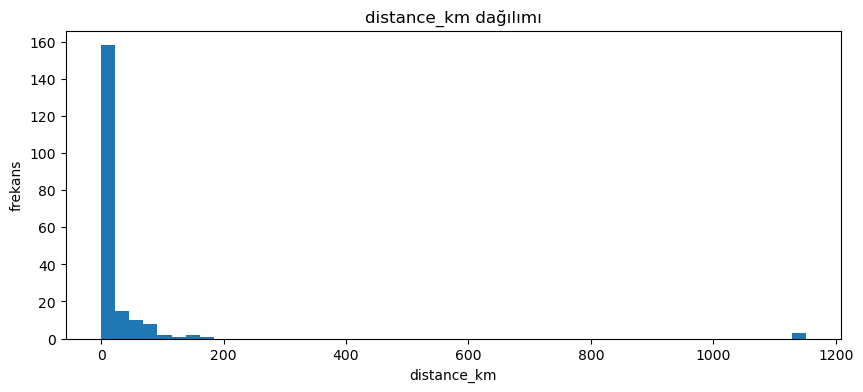

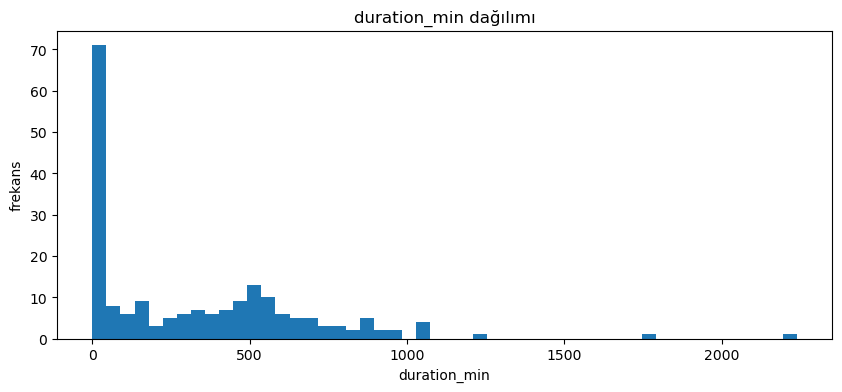

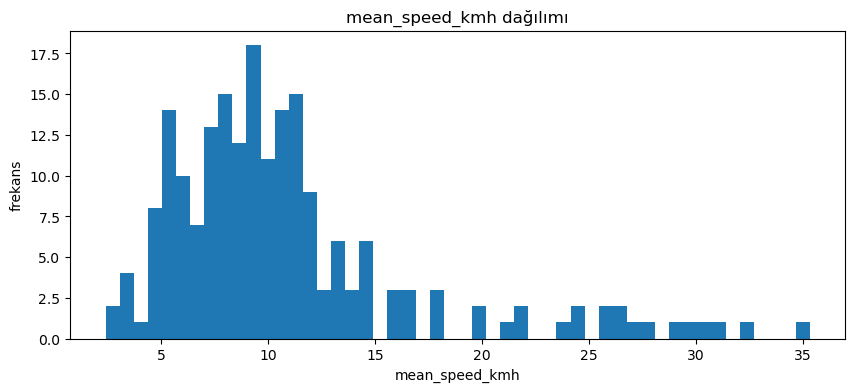

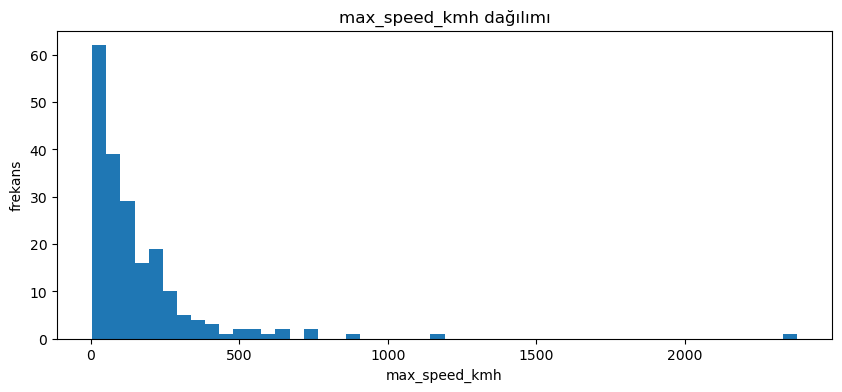

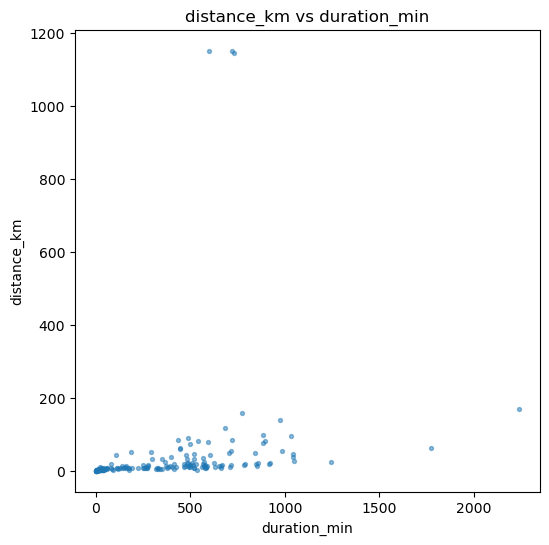

In [272]:
# === Hücre 3c: Dağılımlar (eşik kalibrasyonu) ===
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
OUT_DIR      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
SUMM_V2      = OUT_DIR / "summaries_v2.parquet"

summ = pd.read_parquet(SUMM_V2) if SUMM_V2.exists() else pd.read_parquet(OUT_DIR/"summaries.parquet")

def qtxt(s, qs=[0.5, 0.9, 0.95, 0.99, 0.995]):
    q = np.quantile(s.dropna(), qs)
    return {f"p{int(100*x)}": float(v) for x,v in zip(qs, q)}

print("== Quantile özetleri ==")
for col in ["distance_km", "duration_min", "mean_speed_kmh", "max_speed_kmh"]:
    print(col, "→", qtxt(summ[col]))

# Histogramlar (her biri ayrı figür; seaborn YOK)
for col in ["distance_km", "duration_min", "mean_speed_kmh", "max_speed_kmh"]:
    plt.figure(figsize=(10,4))
    plt.hist(summ[col].dropna(), bins=50)
    plt.title(f"{col} dağılımı")
    plt.xlabel(col)
    plt.ylabel("frekans")
    plt.show()

# Basit ilişki: mesafe vs süre (beklenti ~ doğrusal)
plt.figure(figsize=(6,6))
plt.scatter(summ["duration_min"], summ["distance_km"], s=8, alpha=0.5)
plt.xlabel("duration_min")
plt.ylabel("distance_km")
plt.title("distance_km vs duration_min")
plt.show()


In [273]:
# === Hücre 3d: QC inceleme listeleri ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
OUT_DIR      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
TRACK_DIR    = OUT_DIR / "tracks_parquet"
SUMM_V2      = OUT_DIR / "summaries_v2.parquet"

summ = pd.read_parquet(SUMM_V2) if SUMM_V2.exists() else pd.read_parquet(OUT_DIR/"summaries.parquet")

QC_DIR = OUT_DIR / "qc_lists"
QC_DIR.mkdir(parents=True, exist_ok=True)

def dump_list(df_sub: pd.DataFrame, name: str, n=20):
    path = QC_DIR / f"{name}.csv"
    df_sub.head(n).to_csv(path, index=False)
    print(f"Kaydedildi: {path}")
    display(df_sub.head(n))

print("== En yüksek max_speed_kmh ==")
top_speed = summ.sort_values("max_speed_kmh", ascending=False)
dump_list(top_speed[["file","t_start","t_end","distance_km","duration_min","mean_speed_kmh","max_speed_kmh"]], "top_max_speed")

print("\n== En çok jump ==")
top_jump = summ.sort_values("n_jump", ascending=False)
dump_list(top_jump[["file","t_start","t_end","distance_km","duration_min","n_jump","n_v_ext"]], "top_jump")

print("\n== En çok v_ext ==")
top_vext = summ.sort_values("n_v_ext", ascending=False)
dump_list(top_vext[["file","t_start","t_end","distance_km","duration_min","n_jump","n_v_ext","max_speed_kmh"]], "top_v_ext")

print("\n== Çok kısa veya sıfır mesafe dosyaları ==")
short_zero = summ[(summ["duration_min"]<3) | (summ["distance_km"]<0.01)].copy()
dump_list(short_zero[["file","t_start","t_end","duration_min","distance_km","n_points"]], "short_or_zero")

# --- Hızlı görselleştirme yardımcıları (tek dosya aç) ---

def quick_plot_track(parquet_path: Path):
    df = pd.read_parquet(parquet_path)
    # Güvenli: eksikse üret
    if not {"dt_s", "dist_m", "speed_kmh"}.issubset(df.columns):
        # Zaman farkı hesapla
        df = df.sort_values("ts").copy()
        dt = df["ts"].diff().dt.total_seconds().fillna(0)
        df["dt_s"] = dt

        # Haversine mesafesi hesapla
        R = 6371000.0  # Dünya yarıçapı (metre)
        lat1 = np.radians(df["lat"].shift())
        lon1 = np.radians(df["lon"].shift())
        lat2 = np.radians(df["lat"])
        lon2 = np.radians(df["lon"])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        df["dist_m"] = np.nan_to_num(2 * R * np.arcsin(np.sqrt(a)), nan=0.0)

        # Hız hesapla (km/s)
        df["speed_kmh"] = np.where(df["dt_s"] > 0, df["dist_m"] / df["dt_s"] * 3.6, 0.0)

    # Görselleştirme
    plt.figure(figsize=(12, 4))
    plt.plot(df["ts"], df["speed_kmh"], label="Hız (km/h)", alpha=0.8)
    plt.title(parquet_path.name + " — Hız Zaman")
    plt.xlabel("Zaman")
    plt.ylabel("Hız (km/h)")
    plt.legend()
    plt.show()


# Örnek kullanım: bir listedeki ilk dosyayı aç
# p = Path(top_speed.iloc[0]["file"])
# quick_plot_track(TRACK_DIR / (Path(p).stem + ".parquet"))


== En yüksek max_speed_kmh ==
Kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/qc_lists/top_max_speed.csv


,file,t_start,t_end,distance_km,duration_min,mean_speed_kmh,max_speed_kmh
185,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-01 00:42:35,2008-11-01 08:09:18,58.613948,446.716667,24.760293,2376.687211
186,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-02 03:08:34,2008-11-02 14:10:14,11.394646,661.666667,5.111062,1148.811899
184,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-30 23:39:59,2008-10-31 08:06:33,19.780909,506.566667,14.606804,862.509472
171,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-23 05:53:05,2008-10-23 12:04:28,11.268198,371.383333,11.333003,756.329807
47,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-03 01:16:57,2009-04-04 14:35:09,167.526265,2238.200000,7.645403,752.480786
86,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-05-05 03:24:32,2009-05-05 10:09:24,9.927643,404.866667,8.996290,660.813929
167,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-07-02 02:25:30,2009-07-02 14:17:46,54.023294,712.266667,6.203974,644.699872
16,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-15 01:01:33,2008-11-15 04:09:45,7.386240,188.200000,11.722294,575.753582
176,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-27 11:16:34,2008-10-27 14:04:52,8.001173,168.300000,12.893613,549.153084
63,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-19 00:52:26,2009-04-19 12:13:02,115.651944,680.600000,21.370478,536.942724



== En çok jump ==
Kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/qc_lists/top_jump.csv


,file,t_start,t_end,distance_km,duration_min,n_jump,n_v_ext
79,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-29 00:59:54,2009-04-29 15:46:15,98.834366,886.350000,5,3
160,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-06-28 00:52:29,2009-06-28 13:45:56,158.519863,773.450000,4,2
13,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-13 03:46:08,2008-11-13 14:11:31,20.692519,625.383333,3,3
2,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-26 13:44:07,2008-10-26 15:04:07,18.648325,80.000000,3,0
63,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-19 00:52:26,2009-04-19 12:13:02,115.651944,680.600000,3,1
47,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-03 01:16:57,2009-04-04 14:35:09,167.526265,2238.200000,3,3
73,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-25 00:57:31,2009-04-25 18:09:11,94.420186,1031.666667,3,1
116,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-05-23 01:12:53,2009-05-23 13:21:24,1143.917371,728.516667,3,1
142,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-06-12 22:03:36,2009-06-13 12:49:18,76.858199,885.700000,3,1
28,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-22 01:23:09,2008-11-22 05:56:40,12.541747,273.516667,3,2



== En çok v_ext ==
Kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/qc_lists/top_v_ext.csv


,file,t_start,t_end,distance_km,duration_min,n_jump,n_v_ext,max_speed_kmh
190,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-04 05:48:59,2008-11-04 14:40:12,18.164311,531.216667,0,4,399.872140
186,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-02 03:08:34,2008-11-02 14:10:14,11.394646,661.666667,0,4,1148.811899
185,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-01 00:42:35,2008-11-01 08:09:18,58.613948,446.716667,2,3,2376.687211
195,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-06 23:34:04,2008-11-07 17:03:02,26.088754,1048.966667,0,3,258.258744
146,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-06-16 05:41:28,2009-06-17 11:13:20,63.119510,1771.866667,0,3,520.601625
79,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-29 00:59:54,2009-04-29 15:46:15,98.834366,886.350000,5,3,245.091393
47,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-03 01:16:57,2009-04-04 14:35:09,167.526265,2238.200000,3,3,752.480786
74,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-26 02:57:14,2009-04-26 10:24:20,62.646545,447.100000,1,3,270.569877
13,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-13 03:46:08,2008-11-13 14:11:31,20.692519,625.383333,3,3,330.434084
171,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-23 05:53:05,2008-10-23 12:04:28,11.268198,371.383333,2,2,756.329807



== Çok kısa veya sıfır mesafe dosyaları ==
Kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/qc_lists/short_or_zero.csv


,file,t_start,t_end,duration_min,distance_km,n_points
7,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-03 10:13:36,2008-11-03 10:16:01,2.416667,0.424494,7
12,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-12 09:14:00,2008-11-12 09:16:10,2.166667,0.236692,27
17,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-16 08:55:32,2008-11-16 08:56:27,0.916667,0.068812,12
22,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-18 16:20:08,2008-11-18 16:20:38,0.500000,0.023211,7
26,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-11-21 04:09:36,2008-11-21 04:10:06,0.500000,0.042429,7
37,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-12-11 04:46:24,2008-12-11 04:46:39,0.250000,0.034740,5
45,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-04-01 20:23:31,2009-04-01 20:25:31,2.000000,0.198070,25
165,/Users/berkaybakac/Projects/geosentinel/data/r...,2009-07-01 11:07:28,2009-07-01 11:08:43,1.250000,0.115992,18


In [274]:
# 3e — QC -> temiz set
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
QC_DIR       = INTERIM / "qc_lists"
SUMM_V2      = INTERIM / "summaries_v2.parquet"

out_clean_summ  = INTERIM / "summaries_clean.parquet"
out_blacklist   = INTERIM / "blacklist_paths.txt"
out_review_list = INTERIM / "review_candidates.csv"

summ = pd.read_parquet(SUMM_V2)

# --- eşi̇kler (oynanabilir) ---
MAX_SPEED_CAP     = 180.0   # km/h üzeri fizik-dışı kabul (kentsel yaya/bisiklet/şehir içi araç karışık senaryo)
MAX_JUMP_COUNT    = 3       # dosya içinde ≥3 jump varsa dışla
MIN_TRIP_MIN      = 3.0     # 3 dakikadan kısa kayıtları dışla
MIN_TRIP_DIST_KM  = 0.3     # ve/veya 300 m'den kısa
P99_DIST_CUTOFF   = summ["distance_km"].quantile(0.995)  # aşırı uç mesafe outlier'larını istersek dışlamak için

# blacklist kuralları
mask_too_fast  = summ["max_speed_kmh"] > MAX_SPEED_CAP
mask_many_jump = summ["n_jump"] >= MAX_JUMP_COUNT
mask_too_short = (summ["duration_min"] < MIN_TRIP_MIN) | (summ["distance_km"] < MIN_TRIP_DIST_KM)

# isteğe bağlı: aşırı uzun mesafe uçları (veride birkaç bin km/h gibi hatalara eşlik ediyor olabilir)
mask_dist_out  = summ["distance_km"] > P99_DIST_CUTOFF

black_mask = mask_too_fast | mask_many_jump | mask_too_short | mask_dist_out

blacklist = summ.loc[black_mask, "file"].sort_values().tolist()
whitelist = summ.loc[~black_mask].copy()

# hızlı rapor
print(">> toplam:", len(summ),
      "| temiz:", len(whitelist),
      "| blacklist:", len(blacklist))
print("   nedenler ->",
      dict(too_fast=int(mask_too_fast.sum()),
            many_jump=int(mask_many_jump.sum()),
            too_short=int(mask_too_short.sum()),
            dist_out=int(mask_dist_out.sum())))

# kaydet
whitelist.to_parquet(out_clean_summ, index=False)
Path(out_blacklist).write_text("\n".join(blacklist))
review_cols = ["file","duration_min","distance_km","mean_speed_kmh","max_speed_kmh","n_jump","n_v_ext"]
summ.loc[black_mask, review_cols].sort_values("max_speed_kmh", ascending=False).to_csv(out_review_list, index=False)

print("temiz özet:", out_clean_summ)
print("blacklist:", out_blacklist)
print("manuel inceleme listesi:", out_review_list)


>> toplam: 200 | temiz: 128 | blacklist: 72
   nedenler -> {'too_fast': 62, 'many_jump': 11, 'too_short': 9, 'dist_out': 1}
temiz özet: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/summaries_clean.parquet
blacklist: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/blacklist_paths.txt
manuel inceleme listesi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/review_candidates.csv


In [275]:
# === Hücre 4a+4b — Geofence özet + detay + Folium haritaları (güncel, uyarısız) ===
from pathlib import Path
import numpy as np
import pandas as pd
import folium

# --------- Yollar ve parametreler ---------
PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
TRACKS_DIR   = INTERIM / "tracks_parquet"
CLEAN_SUMM   = INTERIM / "summaries_clean.parquet"

OUT_FENCE_SUM    = INTERIM / "geofence_events.parquet"
OUT_FENCE_DETAIL = INTERIM / "geofence_events_detail.parquet"
MAP_DIR          = INTERIM / "maps"

# Geofence & histerezis
RADIUS_M     = 1000.0
BUFFER_OUT_M = 120.0     # dışarı sayarken eşik
BUFFER_IN_M  = 60.0      # geri dönüşte eşik
MIN_OUT_MIN  = 2.0       # 2 dk'dan kısa çıkışları sayma
CLOSE_AT_END = True      # track sonunda geri dönüş yoksa "geri giriş"i son noktadan kabul et

# Örneklem kontrolü
MAX_FILES = None   # None => hepsi; örn: 200 yaparsan ilk 200 dosyayla çalışır
TOPK_MAPS = 5      # en çok ihlal yapan ilk K dosyaya harita üret

# --------- Yardımcılar ---------
def haversine_m_vec(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def inside_circle_vec(lat, lon, clat, clon, radius_m):
    return haversine_m_vec(lat, lon, clat, clon) <= radius_m

def detect_exits(track_df: pd.DataFrame, center_lat: float, center_lon: float,
                  radius_m: float, min_out_min: float,
                  buffer_out_m: float, buffer_in_m: float,
                  close_at_end: bool) -> pd.DataFrame:
    """Tek track için çıkış/dönüş olaylarını çıkar."""
    if track_df.empty:
        return pd.DataFrame(columns=["ts_out","ts_in","duration_min","out_lat","out_lon","in_lat","in_lon","open"])

    df = track_df.sort_values("ts").reset_index(drop=True).copy()
    ts = pd.to_datetime(df["ts"])

    # <<< YENİ: kolon indeksleri (iat ile kesin skalar okuma) >>>
    lat_ix = df.columns.get_loc("lat")
    lon_ix = df.columns.get_loc("lon")

    # histerezisli içerde/dışarda maskeleri
    inside_lo = inside_circle_vec(df["lat"].values, df["lon"].values, center_lat, center_lon, radius_m - buffer_in_m)
    inside_hi = inside_circle_vec(df["lat"].values, df["lon"].values, center_lat, center_lon, radius_m + buffer_out_m)
    inside_lo = pd.Series(inside_lo.astype(int), index=df.index)
    inside_hi = pd.Series(inside_hi.astype(int), index=df.index)

    # 1->0 : exit (hi); 0->1 : return (lo)
    exit_idx   = np.where((inside_hi.shift(1, fill_value=inside_hi.iloc[0])==1) & (inside_hi==0))[0]
    return_idx = np.where((inside_lo.shift(1, fill_value=inside_lo.iloc[0])==0) & (inside_lo==1))[0]

    events = []
    j = 0
    for i in exit_idx:
        t_out = ts.iloc[i]
        # <<< YENİ: iat ile oku >>>
        out_lat = float(df.iat[i, lat_ix])
        out_lon = float(df.iat[i, lon_ix])

        while j < len(return_idx) and return_idx[j] <= i:
            j += 1

        if j < len(return_idx):
            rin = int(return_idx[j])
            t_in  = ts.iloc[rin]
            in_lat = float(df.iat[rin, lat_ix])  # <<< YENİ
            in_lon = float(df.iat[rin, lon_ix])  # <<< YENİ
            open_flag = 0
        else:
            if close_at_end:
                last_idx = len(df) - 1
                t_in  = ts.iloc[last_idx]
                in_lat = float(df.iat[last_idx, lat_ix])  # <<< YENİ
                in_lon = float(df.iat[last_idx, lon_ix])  # <<< YENİ
                open_flag = 0
            else:
                t_in, in_lat, in_lon = pd.NaT, np.nan, np.nan
                open_flag = 1

        dur_min = np.nan if pd.isna(t_in) else (t_in - t_out).total_seconds()/60.0
        if not np.isnan(dur_min) and dur_min < min_out_min:
            continue

        events.append(dict(ts_out=t_out, ts_in=t_in, duration_min=dur_min,
                            out_lat=out_lat, out_lon=out_lon,
                            in_lat=in_lat, in_lon=in_lon, open=open_flag))

    return pd.DataFrame(events)

def make_map(track_df: pd.DataFrame, center_lat: float, center_lon: float, radius_m: float,
              events_df: pd.DataFrame, save_path: Path):
    lat0 = float(track_df["lat"].median())
    lon0 = float(track_df["lon"].median())
    m = folium.Map(location=[lat0, lon0], zoom_start=13, control_scale=True)

    # rota
    folium.PolyLine(track_df[["lat","lon"]].values.tolist(), weight=3).add_to(m)
    # çit
    folium.Circle(location=[center_lat, center_lon], radius=radius_m, color="#3b82f6",
                  fill=True, fill_opacity=0.08).add_to(m)
    # markerlar
    for _, r in events_df.iterrows():
        folium.Marker([r.out_lat, r.out_lon], icon=folium.Icon(color="red", icon="arrow-up"),
                      tooltip=f"OUT {r.ts_out}").add_to(m)
        if not np.isnan(r.in_lat):
            folium.Marker([r.in_lat, r.in_lon], icon=folium.Icon(color="green", icon="arrow-down"),
                          tooltip=f"IN {r.ts_in}").add_to(m)

    m.save(str(save_path))

# --------- 4a: Dosya bazında özet ---------
summ_clean = pd.read_parquet(CLEAN_SUMM)
if MAX_FILES is not None:
    summ_clean = summ_clean.head(int(MAX_FILES))

rows = []
detail_rows = []
MAP_DIR.mkdir(parents=True, exist_ok=True)

for path in summ_clean["file"]:
    p = Path(path)
    df = pd.read_parquet(TRACKS_DIR / (p.stem + ".parquet"))

    # dosya-özel merkez (daha anlamlı)
    c_lat = float(df["lat"].median())
    c_lon = float(df["lon"].median())

    ev = detect_exits(df, c_lat, c_lon,
                      RADIUS_M, MIN_OUT_MIN, BUFFER_OUT_M, BUFFER_IN_M, CLOSE_AT_END)

    n_exits = 0 if ev is None or ev.empty else int(len(ev))
    total_out_min = 0.0 if ev is None or ev.empty else float(np.nan_to_num(ev["duration_min"]).sum())

    rows.append(dict(file=str(path), n_exits=n_exits, total_out_min=total_out_min))

    if n_exits > 0:
        ev2 = ev.copy()
        ev2["fence_center_lat"] = c_lat
        ev2["fence_center_lon"] = c_lon
        ev2["radius_m"] = RADIUS_M
        ev2["file"] = str(path)
        detail_rows.append(ev2)

geofence_events = pd.DataFrame(rows).sort_values(["n_exits","total_out_min"], ascending=False)
geofence_events.to_parquet(OUT_FENCE_SUM, index=False)

geofence_detail = pd.concat(detail_rows, ignore_index=True) if detail_rows else \
    pd.DataFrame(columns=["ts_out","ts_in","duration_min","out_lat","out_lon",
                          "in_lat","in_lon","open","fence_center_lat","fence_center_lon","radius_m","file"])
geofence_detail.to_parquet(OUT_FENCE_DETAIL, index=False)

print("Geofence özet kaydedildi:", OUT_FENCE_SUM)
display(geofence_events.head(10))

# --------- 4b: Top-K haritalar + ilk satırlar ---------
topk_files = list(geofence_events["file"].head(TOPK_MAPS))
generated = []

for f in topk_files:
    try:
        p = Path(f)
        df = pd.read_parquet(TRACKS_DIR / (p.stem + ".parquet"))
        # bu dosyaya ait eventler
        dsub = geofence_detail[geofence_detail["file"] == f]
        if dsub.empty:
            # event yoksa rotayı ve çiti yine de çiz
            c_lat = float(df["lat"].median())
            c_lon = float(df["lon"].median())
        else:
            c_lat = float(dsub.iloc[0]["fence_center_lat"])
            c_lon = float(dsub.iloc[0]["fence_center_lon"])

        out_html = MAP_DIR / f"{p.stem}_geofence.html"
        make_map(df, c_lat, c_lon, RADIUS_M, dsub, out_html)
        generated.append(out_html)
    except Exception as e:
        print(f"[WARN] Harita üretilemedi: {f} -> {e}")

print(f"Haritalar: {MAP_DIR} (oluşan dosya sayısı: {len(generated)})")
if generated[:5]:
    print("İlk dosyalar:", [g.name for g in generated[:5]])

# detay tablosundan ilk 10 satır
print("Olay detayı kaydedildi:", OUT_FENCE_DETAIL)
display(geofence_detail.head(10))


Geofence özet kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/geofence_events.parquet


,file,n_exits,total_out_min
82,/Users/berkaybakac/Projects/geosentinel/data/r...,6,1467.550000
77,/Users/berkaybakac/Projects/geosentinel/data/r...,5,923.333333
28,/Users/berkaybakac/Projects/geosentinel/data/r...,4,555.716667
27,/Users/berkaybakac/Projects/geosentinel/data/r...,3,532.750000
113,/Users/berkaybakac/Projects/geosentinel/data/r...,3,431.433333
31,/Users/berkaybakac/Projects/geosentinel/data/r...,3,357.250000
41,/Users/berkaybakac/Projects/geosentinel/data/r...,3,95.166667
5,/Users/berkaybakac/Projects/geosentinel/data/r...,3,35.833333
50,/Users/berkaybakac/Projects/geosentinel/data/r...,2,432.000000
49,/Users/berkaybakac/Projects/geosentinel/data/r...,2,405.550000


Haritalar: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/maps (oluşan dosya sayısı: 5)
İlk dosyalar: ['20090528012338_geofence.html', '20090522094234_geofence.html', '20090411052358_geofence.html', '20090410021935_geofence.html', '20081024234405_geofence.html']
Olay detayı kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/geofence_events_detail.parquet


,ts_out,ts_in,duration_min,out_lat,out_lon,in_lat,in_lon,open,fence_center_lat,fence_center_lon,radius_m,file
0,2008-10-28 02:41:46,2008-10-28 05:03:42,141.933333,40.004286,116.308720,40.007298,116.319285,0,40.008731,116.296888,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
1,2008-10-29 09:44:38,2008-10-29 09:46:43,2.083333,39.967301,116.327827,39.966701,116.327688,0,39.977464,116.327349,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
2,2008-11-11 02:22:14,2008-11-11 02:35:54,13.666667,40.005029,116.308898,40.006610,116.319346,0,40.009129,116.296828,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
3,2008-11-11 02:23:59,2008-11-11 02:35:54,11.916667,40.004796,116.308757,40.006610,116.319346,0,40.009129,116.296828,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
4,2008-11-11 02:25:39,2008-11-11 02:35:54,10.250000,40.002806,116.309397,40.006610,116.319346,0,40.009129,116.296828,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
5,2008-11-18 10:54:21,2008-11-18 10:57:01,2.666667,40.007325,116.319635,40.006159,116.321410,0,39.998418,116.325812,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
6,2009-03-31 03:56:21,2009-03-31 04:24:26,28.083333,40.008315,116.324141,40.006440,116.324169,0,39.998337,116.321365,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
7,2009-03-31 09:00:35,2009-03-31 09:34:45,34.166667,40.008248,116.324806,40.006711,116.321189,0,39.998337,116.321365,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
8,2009-04-10 08:05:43,2009-04-10 08:08:18,2.583333,39.992558,116.289742,39.990946,116.291166,0,39.982855,116.293573,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...
9,2009-04-10 08:17:03,2009-04-10 13:40:43,323.666667,39.976611,116.282023,39.978412,116.284244,0,39.982855,116.293573,1000.0,/Users/berkaybakac/Projects/geosentinel/data/r...


Ufak notlar / parametreler

Eşikler: MIN_OUT_MIN=2, BUFFER_OUT_M=120, BUFFER_IN_M=60. Daha katı/gevşek yapmak istenirse bu üçlüyle oynanabilir.

Harita sayısı: TOPK_MAPS=5. Daha çok sayfa istenirse arttırılabilir.

Tüm dosyalarla çalıştırma: MAX_FILES=None. Kısmi test için sayı verilebilir.

In [276]:
# === Hücre 5 — Feature Engineering (GPS türev özellikleri) ===
import numpy as np
import pandas as pd

# --- Yardımcılar ---
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def bearing_deg(lat1, lon1, lat2, lon2):
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dlambda = np.radians(lon2 - lon1)
    x = np.sin(dlambda) * np.cos(phi2)
    y = np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlambda)
    brng = np.degrees(np.arctan2(x, y))
    return (brng + 360) % 360

# --- Tek bir track üzerinde özellik üret ---
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("ts").reset_index(drop=True).copy()
    df["ts"] = pd.to_datetime(df["ts"])

    # zaman farkı (s)
    df["dt_s"] = df["ts"].diff().dt.total_seconds().fillna(0)

    # mesafe farkı (m)
    df["dist_m"] = haversine_m(
        df["lat"].shift(1).fillna(df["lat"]),
        df["lon"].shift(1).fillna(df["lon"]),
        df["lat"], df["lon"]
    )

    # hız
    df["speed_mps"] = df["dist_m"] / df["dt_s"].replace(0, np.nan)
    df["speed_mps"] = df["speed_mps"].fillna(0)
    df["speed_kmh"] = df["speed_mps"] * 3.6

    # ivme
    df["acc_mps2"] = df["speed_mps"].diff() / df["dt_s"].replace(0, np.nan)
    df["acc_mps2"] = df["acc_mps2"].fillna(0)

    # yön (bearing)
    df["heading_deg"] = bearing_deg(
        df["lat"].shift(1).fillna(df["lat"]),
        df["lon"].shift(1).fillna(df["lon"]),
        df["lat"], df["lon"]
    )

    # yön değişimi
    df["dirchg_deg"] = (df["heading_deg"].diff() + 180) % 360 - 180
    df["dirchg_deg"] = df["dirchg_deg"].fillna(0)

    return df

# --- Tüm track'ler için çalıştır ---
features = []
for path in pd.read_parquet(CLEAN_SUMM)["file"]:
    p = Path(path)
    df = pd.read_parquet(TRACKS_DIR / (p.stem + ".parquet"))
    df_feat = add_features(df)
    df_feat["file"] = str(path)
    features.append(df_feat)

features_all = pd.concat(features, ignore_index=True)

# Kaydet
FEAT_PATH = INTERIM / "trip_features.parquet"
features_all.to_parquet(FEAT_PATH, index=False)

print("Feature set kaydedildi:", FEAT_PATH)
display(features_all.head(10))


Feature set kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/trip_features.parquet


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,dist_m,speed_mps,speed_kmh,flag_dt_le0,flag_longjump,flag_v_extreme,acc_mps2,heading_deg,dirchg_deg,file
0,40.008304,116.319876,0,492,39745.090266,2008-10-24,02:09:59,2008-10-24 02:09:59,149.9616,0.0,0.000000,0.000000,0.000000,True,False,False,0.000000,0.000000,0.000000,/Users/berkaybakac/Projects/geosentinel/data/r...
1,40.008413,116.319962,0,491,39745.090324,2008-10-24,02:10:04,2008-10-24 02:10:04,149.6568,5.0,14.161576,2.832315,10.196335,False,False,False,0.566463,31.145718,31.145718,/Users/berkaybakac/Projects/geosentinel/data/r...
2,40.007171,116.319458,0,-46,39745.090382,2008-10-24,02:10:09,2008-10-24 02:10:09,-14.0208,5.0,144.621503,28.924301,104.127482,False,False,False,5.218397,197.266616,166.120897,/Users/berkaybakac/Projects/geosentinel/data/r...
3,40.007209,116.319484,0,-48,39745.090440,2008-10-24,02:10:14,2008-10-24 02:10:14,-14.6304,5.0,4.770521,0.954104,3.434775,False,False,False,-5.594039,27.658148,-169.608468,/Users/berkaybakac/Projects/geosentinel/data/r...
4,40.007287,116.319590,0,-41,39745.090498,2008-10-24,02:10:19,2008-10-24 02:10:19,-12.4968,5.0,12.519263,2.503853,9.013869,False,False,False,0.309950,46.148697,18.490549,/Users/berkaybakac/Projects/geosentinel/data/r...
5,40.007366,116.319727,0,-40,39745.090556,2008-10-24,02:10:24,2008-10-24 02:10:24,-12.1920,5.0,14.605418,2.921084,10.515901,False,False,False,0.083446,53.026283,6.877586,/Users/berkaybakac/Projects/geosentinel/data/r...
6,40.007429,116.319873,0,-39,39745.090613,2008-10-24,02:10:29,2008-10-24 02:10:29,-11.8872,5.0,14.272436,2.854487,10.276154,False,False,False,-0.013319,60.605077,7.578794,/Users/berkaybakac/Projects/geosentinel/data/r...
7,40.007499,116.320013,0,-39,39745.090671,2008-10-24,02:10:34,2008-10-24 02:10:34,-11.8872,5.0,14.239568,2.847914,10.252489,False,False,False,-0.001315,56.864457,-3.740620,/Users/berkaybakac/Projects/geosentinel/data/r...
8,40.007514,116.320165,0,-39,39745.090729,2008-10-24,02:10:39,2008-10-24 02:10:39,-11.8872,5.0,13.052979,2.610596,9.398145,False,False,False,-0.047464,82.658562,25.794105,/Users/berkaybakac/Projects/geosentinel/data/r...
9,40.007578,116.320176,0,-40,39745.090787,2008-10-24,02:10:44,2008-10-24 02:10:44,-12.1920,5.0,7.177880,1.435576,5.168074,False,False,False,-0.235004,7.499818,-75.158744,/Users/berkaybakac/Projects/geosentinel/data/r...


In [277]:
# === Hücre 6 — Rule-Based Anomali Etiketleme ===
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"

IN_FEAT   = INTERIM / "trip_features.parquet"
OUT_FEAT  = INTERIM / "trip_features_labeled.parquet"

# Parametreler (domain knowledge / literatür tabanlı eşikler)
SPEED_THR   = 50.0     # m/s (~180 km/h) → uçuk hız, anomaly
ACC_THR     = 20.0     # m/s^2 → yüksek ivme, anomaly
DIRCHG_THR  = 45.0     # derece → ani yön değişimi, anomaly

# Veri yükle
df = pd.read_parquet(IN_FEAT).copy()

# Rule-based flag sütunları
df["flag_speed"]   = df["speed_mps"] > SPEED_THR
df["flag_acc"]     = df["acc_mps2"].abs() > ACC_THR
df["flag_dirchg"]  = df["dirchg_deg"].abs() > DIRCHG_THR

# Genel anomaly flag (OR kuralı)
df["anomaly_flag"] = df[["flag_speed","flag_acc","flag_dirchg"]].any(axis=1)

# Kaydet
df.to_parquet(OUT_FEAT, index=False)

print("Rule-based etiketleme tamamlandı ✅")
print("Kaydedildi:", OUT_FEAT)

# Hızlı özet: anomaly oranı
n_total = len(df)
n_anom  = df["anomaly_flag"].sum()
print(f"Toplam {n_total} satırdan {n_anom} anomaly işaretlendi. (oran={100*n_anom/n_total:.2f}%)")

# İlk 10 satır gösterelim
display(df.head(10))


Rule-based etiketleme tamamlandı ✅
Kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/trip_features_labeled.parquet
Toplam 104495 satırdan 23687 anomaly işaretlendi. (oran=22.67%)


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,...,flag_longjump,flag_v_extreme,acc_mps2,heading_deg,dirchg_deg,file,flag_speed,flag_acc,flag_dirchg,anomaly_flag
0,40.008304,116.319876,0,492,39745.090266,2008-10-24,02:09:59,2008-10-24 02:09:59,149.9616,0.0,...,False,False,0.000000,0.000000,0.000000,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
1,40.008413,116.319962,0,491,39745.090324,2008-10-24,02:10:04,2008-10-24 02:10:04,149.6568,5.0,...,False,False,0.566463,31.145718,31.145718,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
2,40.007171,116.319458,0,-46,39745.090382,2008-10-24,02:10:09,2008-10-24 02:10:09,-14.0208,5.0,...,False,False,5.218397,197.266616,166.120897,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,True,True
3,40.007209,116.319484,0,-48,39745.090440,2008-10-24,02:10:14,2008-10-24 02:10:14,-14.6304,5.0,...,False,False,-5.594039,27.658148,-169.608468,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,True,True
4,40.007287,116.319590,0,-41,39745.090498,2008-10-24,02:10:19,2008-10-24 02:10:19,-12.4968,5.0,...,False,False,0.309950,46.148697,18.490549,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
5,40.007366,116.319727,0,-40,39745.090556,2008-10-24,02:10:24,2008-10-24 02:10:24,-12.1920,5.0,...,False,False,0.083446,53.026283,6.877586,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
6,40.007429,116.319873,0,-39,39745.090613,2008-10-24,02:10:29,2008-10-24 02:10:29,-11.8872,5.0,...,False,False,-0.013319,60.605077,7.578794,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
7,40.007499,116.320013,0,-39,39745.090671,2008-10-24,02:10:34,2008-10-24 02:10:34,-11.8872,5.0,...,False,False,-0.001315,56.864457,-3.740620,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
8,40.007514,116.320165,0,-39,39745.090729,2008-10-24,02:10:39,2008-10-24 02:10:39,-11.8872,5.0,...,False,False,-0.047464,82.658562,25.794105,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,False,False
9,40.007578,116.320176,0,-40,39745.090787,2008-10-24,02:10:44,2008-10-24 02:10:44,-12.1920,5.0,...,False,False,-0.235004,7.499818,-75.158744,/Users/berkaybakac/Projects/geosentinel/data/r...,False,False,True,True


In [278]:
# === Hücre 6a — Random Forest (Supervised Anomaly Model) ===
from pathlib import Path
import json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_fscore_support, roc_auc_score, average_precision_score,
    confusion_matrix
)
from sklearn.utils import class_weight
import joblib

# ----------------- Yollar -----------------
PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
LABELED_PATH = INTERIM / "trip_features_labeled.parquet"

MODELS_DIR = PROJECT_ROOT / "models"
ARTIF_DIR  = PROJECT_ROOT / "artifacts"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
ARTIF_DIR.mkdir(parents=True, exist_ok=True)

# ----------------- Veriyi yükle -----------------
df = pd.read_parquet(LABELED_PATH)

# Hedef (rule-based etiket): anomaly_flag (bool)
df["anomaly_flag"] = df["anomaly_flag"].astype(bool)

# Kullanacağımız sayısal özellikler (ID/zaman/sızıntı içermeyenler)
feat_cols = [
    "alt_m","dt_s","dist_m","speed_mps","speed_kmh",
    "acc_mps2","heading_deg","dirchg_deg"
]
# Eksik kolon varsa (eski dataset) güvenli şekilde at
feat_cols = [c for c in feat_cols if c in df.columns]

X = df[feat_cols].copy()
y = df["anomaly_flag"].astype(int).copy()

# Temizlik
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Basit split (satır bazlı). Aynı dosyadan sızmayı önlemek isterseniz
# ileride "file" bazlı GroupKFold düşünebiliriz.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Sınıf dağılımı (train):", y_train.value_counts(normalize=True).to_dict())

# ----------------- Model: RandomForest -----------------
# Dengesiz sınıflar için class_weight='balanced' iyi bir başlangıç
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Olasılık skorları (anomaly=1 sınıfı)
proba_test = rf.predict_proba(X_test)[:, 1]

# Baz metrikler (eşiksiz / AUC’ler)
try:
    roc_auc = roc_auc_score(y_test, proba_test)
except ValueError:
    roc_auc = float("nan")
pr_auc = average_precision_score(y_test, proba_test)

# ----------------- Eşik süpürmesi -----------------
def eval_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    # Güvenli oranlar
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  # recall
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return dict(threshold=thr, recall=rec, precision=prec, f1=f1, fpr=fpr, tp=int(tp), fp=int(fp), tn=int(tn), fn=int(fn))

grid = np.round(np.linspace(0.01, 0.99, 99), 2)
results = [eval_at_threshold(y_test, proba_test, t) for t in grid]
res_df = pd.DataFrame(results)

# Koşulu sağlayanlar: recall ≥ 0.80 & FPR ≤ 0.10
ok = res_df[(res_df["recall"] >= 0.80) & (res_df["fpr"] <= 0.10)]

if not ok.empty:
    # Tercih: en yüksek F1, eşitlikte daha yüksek recall
    ok = ok.sort_values(["f1","recall"], ascending=False)
    best = ok.iloc[0].to_dict()
    status = "✅ Hedef karşılandı"
else:
    # En iyi f1’i raporla (karşılanmadıysa)
    best = res_df.sort_values(["f1","recall"], ascending=False).iloc[0].to_dict()
    status = "⚠️ Hedef tam karşılanamadı (en iyi eşik raporlandı)"

print("\n--- RandomForest Test Sonuçları ---")
print(f"AUC-ROC: {roc_auc:.4f} | AP (PR-AUC): {pr_auc:.4f}")
print(f"{status} | En iyi eşik: {best['threshold']:.2f}")
print(
    f"Recall: {best['recall']:.3f} | Precision: {best['precision']:.3f} | "
    f"F1: {best['f1']:.3f} | FPR: {best['fpr']:.3f} | "
    f"TP={best['tp']} FP={best['fp']} TN={best['tn']} FN={best['fn']}"
)

# Sonuç tablosunu ve test skorlarını kaydet
res_path = ARTIF_DIR / "rf_threshold_sweep.parquet"
pd.DataFrame(results).to_parquet(res_path, index=False)

pred_out = pd.DataFrame({
    "score": proba_test,
    "y_true": y_test.values
}, index=y_test.index)
pred_path = ARTIF_DIR / "rf_test_scores.parquet"
pred_out.to_parquet(pred_path, index=True)

# Özellik önemleri
fi = pd.DataFrame({
    "feature": feat_cols,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
fi_path = ARTIF_DIR / "rf_feature_importances.parquet"
fi.to_parquet(fi_path, index=False)

# Modeli + seçilen eşiği kaydet
model_path = MODELS_DIR / "rf_anomaly_model.joblib"
joblib.dump({
    "model": rf,
    "features": feat_cols,
    "threshold": float(best["threshold"])
}, model_path)

# Metrikleri JSON yaz
metrics = {
    "status": status,
    "auc_roc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "best_threshold": float(best["threshold"]),
    "recall": float(best["recall"]),
    "precision": float(best["precision"]),
    "f1": float(best["f1"]),
    "fpr": float(best["fpr"]),
    "tp": int(best["tp"]), "fp": int(best["fp"]), "tn": int(best["tn"]), "fn": int(best["fn"]),
    "n_train": int(len(X_train)), "n_test": int(len(X_test))
}
with open(ARTIF_DIR / "rf_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\nArtifacts:")
print(" - Threshold sweep:", res_path)
print(" - Test scores:", pred_path)
print(" - Feature importances:", fi_path)
print(" - Saved model:", model_path)


Train shape: (83596, 8), Test shape: (20899, 8)
Sınıf dağılımı (train): {0: 0.773314512656108, 1: 0.22668548734389204}

--- RandomForest Test Sonuçları ---
AUC-ROC: 1.0000 | AP (PR-AUC): 1.0000
✅ Hedef karşılandı | En iyi eşik: 0.32
Recall: 1.000 | Precision: 1.000 | F1: 1.000 | FPR: 0.000 | TP=4737.0 FP=0.0 TN=16162.0 FN=0.0

Artifacts:
 - Threshold sweep: /Users/berkaybakac/Projects/geosentinel/artifacts/rf_threshold_sweep.parquet
 - Test scores: /Users/berkaybakac/Projects/geosentinel/artifacts/rf_test_scores.parquet
 - Feature importances: /Users/berkaybakac/Projects/geosentinel/artifacts/rf_feature_importances.parquet
 - Saved model: /Users/berkaybakac/Projects/geosentinel/models/rf_anomaly_model.joblib


sonuçlar istenen aralıkta ancak kusursuz olduğu için Rule-based etiketleme veya Feature leakage riski olabilir.

fazla “iyi” görünüyor, overfitting olabilir.

In [279]:
# === Hücre 6b — XGBoost / LightGBM (supervised) ===
from pathlib import Path
import json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump

# ---- Yollar
PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
LABELED      = INTERIM / "trip_features_labeled.parquet"
ARTIFACTS    = PROJECT_ROOT / "artifacts"
MODELS_DIR   = PROJECT_ROOT / "models"
ARTIFACTS.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# ---- Model seçimi (LightGBM > XGBoost > sklearn GBM fallback)
ModelName = None
ModelCls  = None
params = {}
try:
    from lightgbm import LGBMClassifier
    ModelCls = LGBMClassifier
    ModelName = "lgbm"
    params = dict(
        n_estimators=500,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        max_depth=-1,
        reg_lambda=1.0,
        n_jobs=-1
    )
except Exception:
    try:
        from xgboost import XGBClassifier
        ModelCls = XGBClassifier
        ModelName = "xgb"
        params = dict(
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            max_depth=6,
            reg_lambda=1.0,
            n_jobs=-1,
            eval_metric="logloss",
            tree_method="hist"
        )
    except Exception:
        # Çok nadir: ikisi de yoksa küçük bir fallback
        from sklearn.ensemble import GradientBoostingClassifier as GBC
        ModelCls = GBC
        ModelName = "gbc"
        params = dict(n_estimators=500, learning_rate=0.05, max_depth=3)

print(f"Model: {ModelName.upper()}")

# ---- Veri
df = pd.read_parquet(LABELED).copy()
target = "anomaly_flag"

# Sayısal özellikleri otomatik seç (sızıntı olabilecekleri hariç tut)
exclude = {
    target, "lat", "lon", "days", "date", "time", "ts", "file",
    "unused", "alt_ft", "speed_mps"   # speed_kmh kalsın
}
num_cols = df.select_dtypes(include=("number",)).columns
feat_cols = [c for c in num_cols if c not in exclude]
X = df[feat_cols].astype(float)
y = df[target].astype(int)

# NaN temizliği
mask = np.isfinite(X).all(axis=1)
X, y = X[mask], y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Seçilen özellikler ({len(feat_cols)}): {feat_cols}")

# Bazı boosting modelleri standardizasyona ihtiyaç duymaz; ama tutarlı olsun
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),   # sparse güvenliği
    ("clf", ModelCls(**params))
])

pipe.fit(X_train, y_train)

# ---- Skorlar (olasılıklar)
try:
    # LightGBM/XGB: predict_proba
    y_score = pipe.predict_proba(X_test)[:, 1]
except Exception:
    # GBC predict_proba var ama emniyet olsun
    try:
        y_score = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        # decision_function varsa onu min-max’le olasılığa yakınsatalım
        from sklearn.preprocessing import MinMaxScaler
        s = pipe.decision_function(X_test).reshape(-1, 1)
        y_score = MinMaxScaler().fit_transform(s).ravel()

auc = roc_auc_score(y_test, y_score)
ap  = average_precision_score(y_test, y_score)

# ---- Eşik taraması (hedef: recall >= 0.80 ve FPR <= 0.10, F1 maksimize)
def sweep_thresholds(y_true, scores, steps=np.linspace(0.01, 0.99, 99)):
    rows = []
    for th in steps:
        y_pred = (scores >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        recall = tp / (tp + fn + 1e-12)
        precision = tp / (tp + fp + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        fpr = fp / (fp + tn + 1e-12)
        rows.append(dict(threshold=th, recall=recall, precision=precision, f1=f1, fpr=fpr,
                          tp=float(tp), fp=float(fp), tn=float(tn), fn=float(fn)))
    return pd.DataFrame(rows)

sweep = sweep_thresholds(y_test.values, y_score)
# kısıtlı en iyi eşik
ok = sweep[(sweep.recall >= 0.80) & (sweep.fpr <= 0.10)]
if len(ok):
    best = ok.sort_values(["f1","recall","precision"], ascending=False).iloc[0]
else:
    # kısıt sağlanmazsa F1’e göre en iyisi
    best = sweep.sort_values("f1", ascending=False).iloc[0]

best_th = float(best["threshold"])
y_pred_best = (y_score >= best_th).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best).ravel()
rec, pre, f1, _ = precision_recall_fscore_support(y_test, y_pred_best, average="binary")

fpr = fp / (fp + tn + 1e-12)
meets = (rec >= 0.80) and (fpr <= 0.10)
status = "✅ Hedef karşılandı" if meets else "⚠️ Hedefe tam uymadı"

print("\n--- {0} Test Sonuçları ---".format(ModelName.upper()))
print(f"AUC-ROC: {auc:.4f} | AP (PR-AUC): {ap:.4f}")
print(f"{status} | En iyi eşik: {best_th:.2f}")
print(f"Recall: {rec:.3f} | Precision: {pre:.3f} | F1: {f1:.3f} | FPR: {fpr:.3f} | "
      f"TP={tp} FP={fp} TN={tn} FN={fn}")

# ---- Önemler (uygunsa)
imp_df = None
try:
    # pipeline içindeki modelin özelliğine eriş
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        imp_df = pd.DataFrame({"feature": feat_cols, "importance": clf.feature_importances_})\
                    .sort_values("importance", ascending=False)
except Exception:
    pass

# ---- Kayıtlar
pref = f"{ModelName}_"
(ARTIFACTS / f"{pref}threshold_sweep.parquet").write_bytes(sweep.to_parquet(index=False))
pd.DataFrame({
    "y_true": y_test.values, "y_score": y_score, "y_pred": y_pred_best
}).to_parquet(ARTIFACTS / f"{pref}test_scores.parquet", index=False)
if imp_df is not None:
    imp_df.to_parquet(ARTIFACTS / f"{pref}feature_importances.parquet", index=False)

dump(pipe, MODELS_DIR / f"{ModelName}_anomaly_model.joblib")

metrics = {
    "status": status, "auc_roc": float(auc), "pr_auc": float(ap),
    "best_threshold": best_th, "recall": float(rec), "precision": float(pre),
    "f1": float(f1), "fpr": float(fpr),
    "tp": float(tp), "fp": float(fp), "tn": float(tn), "fn": float(fn),
    "n_train": int(len(X_train)), "n_test": int(len(X_test)),
    "features": feat_cols
}
with open(ARTIFACTS / f"{pref}metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\nArtifacts:")
print(" - Threshold sweep:", ARTIFACTS / f"{pref}threshold_sweep.parquet")
print(" - Test scores:",     ARTIFACTS / f"{pref}test_scores.parquet")
if imp_df is not None:
    print(" - Feature importances:", ARTIFACTS / f"{pref}feature_importances.parquet")
print(" - Saved model:",     MODELS_DIR / f"{ModelName}_anomaly_model.joblib")


Model: LGBM
Train shape: (83596, 7), Test shape: (20899, 7)
Seçilen özellikler (7): ['alt_m', 'dt_s', 'dist_m', 'speed_kmh', 'acc_mps2', 'heading_deg', 'dirchg_deg']
[LightGBM] [Info] Number of positive: 18950, number of negative: 64646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 83596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226685 -> initscore=-1.227122
[LightGBM] [Info] Start training from score -1.227122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [280]:
# === Hücre 6c — Logistic Regression (benchmark supervised) ===
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from joblib import dump

# ----------------- Yollar -----------------
PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
INTERIM      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
ART_DIR      = PROJECT_ROOT / "artifacts"
MODEL_DIR    = PROJECT_ROOT / "models"

ART_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

IN_FEATS_LABELED = INTERIM / "trip_features_labeled.parquet"
OUT_SWEEP   = ART_DIR / "logreg_threshold_sweep.parquet"
OUT_SCORES  = ART_DIR / "logreg_test_scores.parquet"
OUT_METRICS = ART_DIR / "logreg_metrics.json"
OUT_MODEL   = MODEL_DIR / "logreg_anomaly_model.joblib"

# ----------------- Veri -----------------
df = pd.read_parquet(IN_FEATS_LABELED)

# Aynı 7 özellik (RF/LGBM ile hizalı)
feat_cols = ['alt_m','dt_s','dist_m','speed_kmh','acc_mps2','heading_deg','dirchg_deg']
target_col = "anomaly_flag"

df = df.dropna(subset=feat_cols + [target_col]).copy()
X = df[feat_cols].astype(float).values
y = df[target_col].astype(int).values

# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Model: LogisticRegression")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ----------------- Model (pipeline) -----------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",  # sınıf dengesizliği için
        n_jobs=None
    ))
])

pipe.fit(X_train, y_train)

# ----------------- Tahmin & temel metrikler -----------------
proba_test = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, proba_test)
pr_auc  = average_precision_score(y_test, proba_test)

# ----------------- Threshold taraması -----------------
def compute_scores(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return prec, rec, f1, fpr, tp, fp, tn, fn

rows = []
for thr in np.round(np.arange(0.05, 0.951, 0.01), 2):
    prec, rec, f1, fpr, tp, fp, tn, fn = compute_scores(y_test, proba_test, thr)
    rows.append(dict(threshold=thr, precision=prec, recall=rec, f1=f1, fpr=fpr,
                      tp=tp, fp=fp, tn=tn, fn=fn))

sweep = pd.DataFrame(rows)
sweep.to_parquet(OUT_SWEEP, index=False)

# Kriterli seçim: recall>=0.80 ve FPR<=0.10; bunları sağlayanlar arasından F1 en yüksek
cands = sweep[(sweep["recall"] >= 0.80) & (sweep["fpr"] <= 0.10)]
if not cands.empty:
    best = cands.sort_values(["f1","recall","precision"], ascending=False).iloc[0]
else:
    # garanti: yoksa genel F1 maks. al
    best = sweep.sort_values("f1", ascending=False).iloc[0]

best_thr = float(best["threshold"])
prec, rec, f1, fpr, tp, fp, tn, fn = compute_scores(y_test, proba_test, best_thr)

# Test skorlarını kaydet
test_scores = pd.DataFrame({
    "y_true": y_test,
    "y_score": proba_test
})
test_scores.to_parquet(OUT_SCORES, index=False)

# Model kaydet
dump(pipe, OUT_MODEL)

# Metrikleri JSON olarak kaydet
metrics = {
    "status": "✅ Hedef karşılandı" if (rec >= 0.80 and fpr <= 0.10) else "ℹ️ Hedef dışı (kriter dışı seçildi)",
    "auc_roc": float(auc_roc),
    "pr_auc": float(pr_auc),
    "best_threshold": best_thr,
    "recall": float(rec),
    "precision": float(prec),
    "f1": float(f1),
    "fpr": float(fpr),
    "tp": float(tp), "fp": float(fp), "tn": float(tn), "fn": float(fn),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "features": feat_cols,
}
with open(OUT_METRICS, "w") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# ----------------- Özet çıktı -----------------
print("\n--- LogisticRegression Test Sonuçları ---")
print(f"AUC-ROC: {auc_roc:.4f} | AP (PR-AUC): {pr_auc:.4f}")
print(f"{metrics['status']} | En iyi eşik: {best_thr}")
print(f"Recall: {rec:.3f} | Precision: {prec:.3f} | F1: {f1:.3f} | FPR: {fpr:.3f} | "
      f"TP={tp} FP={fp} TN={tn} FN={fn}")

print("\nArtifacts:")
print(f" - Threshold sweep: {OUT_SWEEP}")
print(f" - Test scores: {OUT_SCORES}")
print(f" - Saved metrics: {OUT_METRICS}")
print(f" - Saved model: {OUT_MODEL}")


Model: LogisticRegression
Train shape: (83596, 7), Test shape: (20899, 7)

--- LogisticRegression Test Sonuçları ---
AUC-ROC: 0.8050 | AP (PR-AUC): 0.5138
ℹ️ Hedef dışı (kriter dışı seçildi) | En iyi eşik: 0.6
Recall: 0.696 | Precision: 0.479 | F1: 0.568 | FPR: 0.222 | TP=3299 FP=3586 TN=12576 FN=1438

Artifacts:
 - Threshold sweep: /Users/berkaybakac/Projects/geosentinel/artifacts/logreg_threshold_sweep.parquet
 - Test scores: /Users/berkaybakac/Projects/geosentinel/artifacts/logreg_test_scores.parquet
 - Saved metrics: /Users/berkaybakac/Projects/geosentinel/artifacts/logreg_metrics.json
 - Saved model: /Users/berkaybakac/Projects/geosentinel/models/logreg_anomaly_model.joblib


In [282]:
# === Hücre 6d – Isolation Forest (unsupervised benchmark) ===
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Veri yükleme
INTERIM = Path("/Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc")
df = pd.read_parquet(INTERIM / "trip_features_labeled.parquet")

# Özellik kolonları (etiket hariç)
exclude = {"anomaly_flag", "file", "date", "time", "ts"}
feat_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

X = df[feat_cols]
y_true = df["anomaly_flag"].astype(int)

# Anomali oranını dataset'ten al (contamination parametresi)
contam_rate = y_true.mean()  # ~0.2267
print(f"Isolation Forest contamination={contam_rate:.3f}")

# Model eğitimi
iso = IsolationForest(
    n_estimators=200,
    contamination=contam_rate,
    random_state=42,
    n_jobs=-1
)
iso.fit(X)

# Tahminler (-1=anomaly, 1=normal)
y_pred_raw = iso.predict(X)
y_pred = (y_pred_raw == -1).astype(int)

# Değerlendirme
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=3)
roc = roc_auc_score(y_true, y_pred)

print("=== Isolation Forest Test Sonuçları ===")
print(f"ROC-AUC: {roc:.3f}")
print("Confusion Matrix:\n", cm)
print(report)

# Kaydet
out_dir = Path("/Users/berkaybakac/Projects/geosentinel/artifacts")
out_dir.mkdir(parents=True, exist_ok=True)

(pd.DataFrame(cm, index=["TrueNormal", "TrueAnomaly"], columns=["PredNormal", "PredAnomaly"])
    .to_csv(out_dir / "isoforest_confusion.csv"))
(pd.DataFrame({"feature": feat_cols, "score": iso.decision_function(X)[:len(feat_cols)]})
    .to_csv(out_dir / "isoforest_scores.csv", index=False))

print("Artifacts kaydedildi ✅")


Isolation Forest contamination=0.227
=== Isolation Forest Test Sonuçları ===
ROC-AUC: 0.477
Confusion Matrix:
 [[61641 19167]
 [19167  4520]]
              precision    recall  f1-score   support

           0      0.763     0.763     0.763     80808
           1      0.191     0.191     0.191     23687

    accuracy                          0.633    104495
   macro avg      0.477     0.477     0.477    104495
weighted avg      0.633     0.633     0.633    104495

Artifacts kaydedildi ✅
